# Introduction 

The purpose of this file is to illustrate the utilization of the Splines'n Lines method as programmed in SplinesNLines_py. As one of the motivations for the model is to better infer/interpolate/extrapolate galaxy Spectral Energy Distributions our illustration will be based on simulating SED's based on a prototypical/average profile. On this tutorial we will assume basic basic notions of SED's (e.g. what they are, how are they modelled), on Bayesian statistics (e.g. what a priors, posteriors, and likelihood models are), and Hierarchical models. Knowledge on Functional Data Analysis and Empirical Bayes is useful, but will be reviewed on this tutorial. 



In particular we will follow the following:

1. Some preeliminary material. 
2. Explaining the Splines'n Lines model. 
3. Simulating data and using SplinesNLines_py
4. Practical considerations. 


In [1]:
import SplinesNLines
import numpy as np
import torch
import matplotlib.pyplot as plt 
np.random.seed(202034) #Sets seed for reproductibility. 

# 1. Some preeliminary material. 

In this section we will download the .fits file of one quasar which was recorded by the Sloan Digital Sky Survey, this will be done using the astropy package. 


[Splines'n Lines](https://arxiv.org/abs/2310.19340)

## 1.1 Functional Data Analysis 

In statistical analysis, numbers often represent single units. However there are natural processes, like SED curves, which are better described by continuous functions rather than individual data points. The field of Functional Data Analysis (FDA) provides a collection of statistical tools to analyse populations of this sort. In what follows we will give a necessary, but limited, background for the rest of the tutorial. We refer interested readers to [this review paper](https://www.annualreviews.org/content/journals/10.1146/annurev-statistics-041715-033624), or [this one which is more recent](https://onlinelibrary.wiley.com/doi/full/10.1002/bimj.202300363). 


$$F_o(\lambda) = \theta_{o1}\varphi_1(\lambda) + \theta_{o2} \varphi_2(\lambda) + ... + \theta_{oK} \varphi_K(\lambda) $$

If we had evidence of $o = 1,2,..., O$ spectral profiles, i.e. points observed with observation error , we would be interested in infering the true spectral profile which we will denote a $F_o(\lambda)$. In FDA functions of interest are often, though not exclusively, represented as a finite sum of known functions $\varphi_k(\lambda)$ (e.g. polynomials, splines, or B-Splines) multiplied by function specific (in our case for each $o$) scalars $\theta_{ok}$. The advantage of this approach is that it makes infering the $\theta_{ok}$'s equivalent to infering their corresponding functions. 

As is the case with SED's, the data to estimate such coefficients $\theta_{ok}$ comes in forms of pairs of numbers $(\lambda_{oi}, y_{oi})$, $i = 1,2,...K_o$, note that $K_o$ may be function specific, where $y_{oi}$ corresponds to a random perturbation of $F_o(\lambda_{oi})$ of the form, 


$$ y_{oi} = F_o(\lambda_{oi} ) + \varepsilon_{oi} \;\;\;\; \;\; E\{\varepsilon_{oi}\} = 0$$


The previous two forms allow us to express the relationship between SED specific observations $\textbf{y}_o = (y_{o1}, ..., y_{oK_o})$, their errors  $\boldsymbol{\varepsilon}_o = (\varepsilon_{o1}, ..., \varepsilon_{oK_o})$ , and the evaluated functions $\varphi_k(\lambda_{oi})$ in matrix form. In particular, if $o$ was observed at values $\lambda_{o1}$, $\lambda_{o2}$, ..., $\lambda_{oK_o}$ we may define the matrix, 


$$ \textbf{X}_o = \begin{bmatrix}
                    \varphi_1(\lambda_{o1}) & \varphi_2(\lambda_{o1}) & ... & \varphi_K(\lambda_{o 1}) \\ 
                    \varphi_1(\lambda_{o2}) & \varphi_2(\lambda_{o2}) & ... & \varphi_K(\lambda_{o 2})  \\
                    \vdots & \vdots & ... & \vdots \\ \varphi_1(\lambda_{o K_o}) & \varphi_2(\lambda_{o K_o}) & ... & \varphi_K(\lambda_{o K_o})
                
                    \end{bmatrix}  $$

so that $\textbf{y}_o = \textbf{X}_o \boldsymbol{\theta}_o + \boldsymbol{\varepsilon}_o$. We will refer to $\textbf{X}_o$ as a **design matrix**. 



## 1.2 Smoothing and B-Spline basis functions

A lot of the computational machinery and tools used in FDA are inherited from Smoothing. In a similar context as before, imagine that we observe pairs $(y_i, x_i)$ where $y_i = f(x_i) + \varepsilon_i$ and $E\{ \varepsilon_i\}  = 0$. i.e. the traditional regression problem or $O = 1$ in the previous subsection. Again, we will represent $f$ as a linear combination of basis functions $\hat{f}(x) = \sum_{k}\theta_k \varphi_k(x)$ so that obtaining a point estimate $\hat{f}(x)$ is equivalent to obtaining those of the $\hat{\theta}_k$'s. A matter which we havent touched, though, is how to choose the $\{\varphi_k(x)\}$'s. 


There are many possible basis $\{\varphi_k(x)\}$ to choose from but we, as in the Splines'n Lines method, will use **B-Spline** functions. These are Spline functions, piecewise polynomials, which have very good numerical properties and are equivalent to other basis of the same kind. To obtain a basis of size $B$ whose elements are $m+1$ degree polynomials, one must choose a a collection of $B + m + 2$ knots $t_1 < t_2 < ... < t_{B+m+2}$. Then, by taking  $B_i^{-1}(x) = \mathbb{I}_{[ t_i , t_{i+1} )} (x)$, B-Splines are defined throught the following recursion, 

$$B_i^m (x) = \frac{ x - t_i}{t_{i + m + 1} - t_i}B_i^{m-1}(x) + \frac{t_{i+m+2} - x}{t_{i+m + 2} - t_{i+1}} B_{i+1}^{m-1} (x) $$


In the following cell, we exemplify the previous with the SplinesNLines_py code by graphing $B = 5$ basis functions of degree $m+1 = 3$ and with equally spaced knots in the $[-22, 2]$ interval (including the extremes). More specifically we use the **get_basis_mat_B_Spline_opt** function which has four inputs, 


1. *x_e* a np.array object which was the points on which the B-Splines should be evaluated. 
2. *B* and int with the number of functions in the B-Spline basis. 
3. *m* an integer such that *m+1* is the degree of the B-Splines. 
4. *T* a np.array object with *B + m + 2* knots. 


The method returns an $\Big(len(x\_e) \times B\Big)$ matrix which corresponds to the design matrix induced by the B-Spline basis. Note that the entries of the returned matrix may be used to plot the B-Spline functions. 

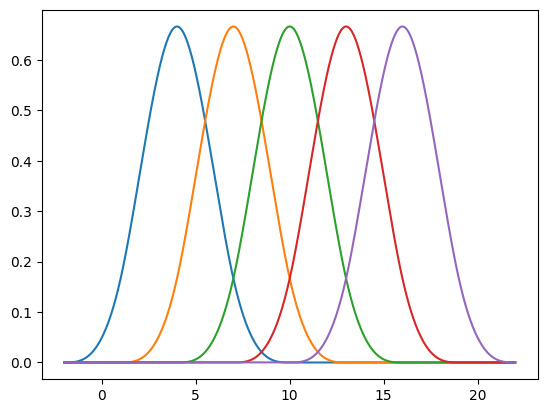

In [2]:

B = 5 #Defines number of spline functions to use
m = 2 #Defines number such that m+1 is the degree of the B-splines. 
T = np.linspace(-2, 22, B + m + 2) #Defines B + m + 2 equally spaced knots. 

x_show = np.linspace(-2, 22, 1500)
X_show = SplinesNLines.get_basis_mat_B_Spline_opt(x_show, B, m, T)
plt.plot(x_show, X_show)
plt.show()

## 1.3 Empirical Bayes

When defining priors for bayesian modelling, one usually must define a collection of hyperparameters $\boldsymbol{\eta}$ which defines the probabilistic chracteristics of our prior distribution $p(\boldsymbol{\theta}|\boldsymbol{\eta})$.  After this, given that we observe $\textbf{y} \sim f(\textbf{y}| \boldsymbol{\theta}, \boldsymbol{\eta})$ one would seek to make posterior inference on $\boldsymbol{\theta}$ throught the posterior distribution 

$$ p(\boldsymbol{\theta}| \textbf{y}, \boldsymbol{\eta}) = \frac{  f(\textbf{y}  | \boldsymbol{\theta}, \boldsymbol{\eta})p(\boldsymbol{\theta}|\boldsymbol{\eta}   )   }{    \int f(\textbf{y}  | \boldsymbol{\theta}, \boldsymbol{\eta})p(\boldsymbol{\theta}|\boldsymbol{\eta}   ) d \boldsymbol{\theta} }$$




A natural quesiton, of course, is how one should select  $\boldsymbol{\eta}$. Under some bayesian narratives, it is argued that  $\boldsymbol{\eta}$ should reflect a users prior knowledge on the possible values that $\boldsymbol{\theta}$ could take. On an *Empirical Bayes* approach, on the other hand, one would seek to obtain $\boldsymbol{\eta}$ from the data itself. Doing so involves two steps, the first to obtain the marginal distribution of the data by *averaging* over all of the possible values of $\boldsymbol{\theta}$, which is simply $p(\textbf{y}|\boldsymbol{\eta})  = \int f(\textbf{y}  | \boldsymbol{\theta}, \boldsymbol{\eta})p(\boldsymbol{\theta}|\boldsymbol{\eta}   ) d \boldsymbol{\theta} $, and then to obtain a datadriven estimate $ \hat{\boldsymbol{\eta}} (\textbf{x})  $, e.g. by a method of maximum likelihood. Later one would work with the posterior distribution, 


$$ p(\boldsymbol{\theta}| \textbf{y}, \hat{\boldsymbol{\eta}} (\textbf{x})  ) = \frac{  f(\textbf{y}  | \boldsymbol{\theta}, \boldsymbol{\eta})p(\boldsymbol{\theta}|\hat{\boldsymbol{\eta}} (\textbf{x})  )   }{    \int f(\textbf{y}  | \boldsymbol{\theta}, \hat{\boldsymbol{\eta}} (\textbf{x})   )p(\boldsymbol{\theta}|\hat{\boldsymbol{\eta}} (\textbf{x})   ) d \boldsymbol{\theta} }$$










# 2. Explaining the Splines'n Lines model 

We know that spectral profiles $F_o(\lambda)$ could be thought of as *smooth* curves if it wasnt for the existance of line profiles, e.g. absorption and emission lines. Let us suppose that we have $l = 1,2,..., L$ line profiles with locations at $\lambda_{ol}^{(loc)}$ and widths $\tau_{ol}$ (These are usually provided by the SDSS).  The [Splines'n Lines method](https://arxiv.org/abs/2310.19340) seeks to better represent the individual line profiles and *smooth component* of $F_o(\lambda)$ by separating them. In particular, each profile is modelled with a gaussian kernel $\kappa(\lambda, \mathcal{X}_o) = \mathcal{N}(\lambda | \lambda_{ol}^{(loc)}, 1/\sigma_{ol}^2)$,  $\mathcal{X}_o = (\lambda_{ol}^{(loc)}, \sigma_{ol})$, and the smooth component with a linear combination of B-Spline functions  $\sum_{k = 1}^B \theta_k \phi_k(\ell) $. In this way, taking $B_f = B + L$,   $F_o(\lambda)$ adquires the following form, 


$$ F_o(\lambda) = \sum_{k = 1}^B \theta_k \phi_k(\ell) + \sum_{k = B + 1}^{B_f}\theta_k \kappa_k(\lambda, \mathcal{X}_o) $$


Now, to model variations in the $F_o(\lambda)$'s the mode assumes that the coefficients $\boldsymbol{\theta}_o = (\theta_{o1}, \theta_{o2}, ..., \theta_{oB_f})^T$ are independent realizations from a multivariate normal with mean $\boldsymbol{\mu} = (\mu_1, \mu_2, ..., \mu_{B_f})^T$ and covariance $\Sigma$. i.e. $\boldsymbol{\theta}_o \overset{ind.}{\sim} \mathcal{N}(\boldsymbol{\theta}|\boldsymbol{\mu}, \Sigma)$. Note that this implies the existance of a mean profile $F_\mu(\lambda) = \sum_{k = 1}^B \mu_k \phi_k(\ell) + \sum_{k = B + 1}^{B_f}\mu_k \kappa_k(\lambda, \mathcal{X}_o)$. Once $\boldsymbol{\theta}_o$ is known for a particular galaxy, the observed values of the spectral profile $y_{oi}$ are modelled as random perturbations from $F_o(\lambda_{oi})$ with a normal model. That is, $y_{oi} \overset{ind.}{\sim} \mathcal{N}(y| F_o(\lambda_{oi}) ,\; \tau_{oi})$ where, once again, $\tau_{oi}$ is provided by the SDSS.  $\boldsymbol{\mu}$ and $\Sigma$ are modelled *a priori* with a unifrom non-informative prior over all of their support, i.e. $p(\boldsymbol{\mu}, \Sigma) \propto 1$. With this, the relationship between the observed data $\textbf{y}_o = (y_{o1}, ..., y_{oK_o})^T$, the unknown coefficients $\boldsymbol{\theta}_o$, and $(\boldsymbol{\mu}, \Sigma)$ is given by the following three level hierarchy, 


$$    \begin{split}
        (\boldsymbol{\mu}, \Sigma) \;\;\sim & \;\;p(\boldsymbol{\mu}, \Sigma) \propto 1 \\
           \boldsymbol{\theta}_o |\boldsymbol{\mu}, \Sigma \; \; \overset{ind.}{\sim} & \;\; \mathcal{N}_{L+B}(\boldsymbol{\theta} \;| \; \boldsymbol{\mu}, \Sigma) \\
           y_{io}|\boldsymbol{\theta}_o  \;\; \overset{ind.}{\sim} & \;\;\mathcal{N}\Big (y \; | \; F_o(\lambda_{oi}) \;, \; \tau_{oi}\Big)
    \end{split} $$ 


Note that, if we define the following design matrix, 


$$\textbf{X}_o = \begin{bmatrix} \phi_1(\ell_{o1}) & ... & \phi_B(\ell_{o1}) & \kappa_1(\lambda_{o1}, \mathcal{X}_o) & ... & \kappa_L(\lambda_{o1}, \mathcal{X}_o)\\

\phi_1(\ell_{o2}) & ... & \phi_B(\ell_{o2}) & \kappa_1(\lambda_{o2}, \mathcal{X}_o) & ... & \kappa_L(\lambda_{o2}, \mathcal{X}_o)\\

\vdots & & & & & \vdots \\

\phi_1(\ell_{oN_o}) & ... & \phi_B(\ell_{oN_o}) & \kappa_1(\lambda_{oN_o}, \mathcal{X}_o) & ... & \kappa_L(\lambda_{oN_o}, \mathcal{X}_o)
    
\end{bmatrix} $$



the third level of the hierarchy may be re-written as $\textbf{y}_o \sim \mathcal{N}_{K_o}(\textbf{y}| \textbf{X}_o \boldsymbol{\theta}_o, \textbf{T}_o)$ where $\textbf{T}_o = diag(\tau_{o1}, ..., \tau_{o K_o})$. 



# 3. Simulating data and using SplinesNLines_py

In this section we will illustrate the use of SplinesNLines_py by making a small simulation study. In particular, we  define a specific $\boldsymbol{\mu}$, $\Sigma$, later to simulate the data of $O = 2000$ spectral profiles. For each special profile, the number of observed points will be a random intger between 50 and 100, and the precision parameters $\tau_{oi}$ will be drawn independently from a uniform distribution $\mathcal{U}(0,10)$. We will include three spectral profiles located at points 1.5, 3.5, and 7.5 with correspondent widths ($\sigma_{ol}$ values ) 1, 2, and 1/2. The rest of the components, namely the $\boldsymbol{\theta}_0$'s and $\textbf{y}_o$'s, will be simulated as the hierarchical model demands. 


Before we beggin, though, we must introduce the function **eval_Line_Profiles_opt** which takes three inputs:

1. *x_e* a numpy array with the points to evaluate each profile. 
2. *loc_vals* a numpy array with the $\lambda_{ol}^{(loc)}$'s. 
3. *width_vals* a numpy array with the $\sigma_{ol}$'s. 


The method returns a $\Big(len(x\_e) \times L \Big)$ matrix which corresponds to the linen profile part of the design matrix $\textbf{X}_o$. 


Simulating galaxy 100
Simulating galaxy 200
Simulating galaxy 300
Simulating galaxy 400
Simulating galaxy 500
Simulating galaxy 600
Simulating galaxy 700
Simulating galaxy 800
Simulating galaxy 900
Simulating galaxy 1000
Simulating galaxy 1100
Simulating galaxy 1200
Simulating galaxy 1300
Simulating galaxy 1400
Simulating galaxy 1500
Simulating galaxy 1600
Simulating galaxy 1700
Simulating galaxy 1800
Simulating galaxy 1900
Simulating galaxy 2000


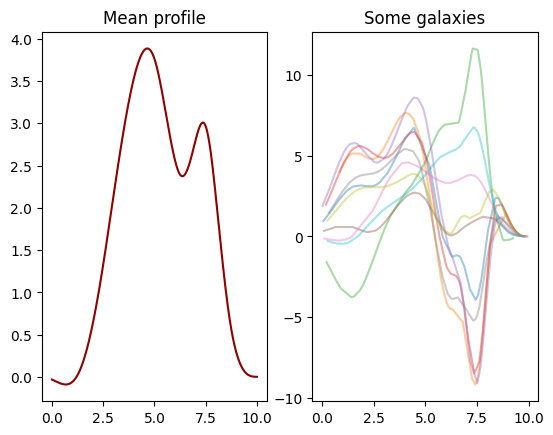

In [3]:
m = 2 #Sets number such that m+1 is the degree for the B-Spline basis functions. 
B = 5 #Sets number of basis functions to use. 
O = 2000 #Sets te number of galaxies to simlate. 
T = np.linspace(0,10, B+m+2) #Generates knots for B-spline basis. 
L = 3 #Sets the number of line profiles to consider. 
mu = np.array([1.0, 3.0, 4.0, 1.5, np.pi, -1, 2.3, 0.7]) #Defines mean vector. 

x_e = np.linspace(0, 10, num = 2000) #Defines points to evaluate mean function (i.e. to visualice it)
X_B =  SplinesNLines.get_basis_mat_B_Spline_opt(x_e, B, m, T) #Creates design matrix for the smooth component. 
X_L = SplinesNLines.eval_Line_Profiles_opt(x_e, loc_vals= np.array([1.5, 3.5, 7.5]), width_vals= np.array([1, 2.0, 0.5])) #Creates design matrix for the line profiles. 

X_mu = np.hstack(( X_B , X_L  ) ) #Obtains full design matrix. 
f_mu = torch.from_numpy(X_mu)@mu #Computes evaluations of mean profile. 



Bf = B + L

A = np.random.normal(size = Bf).reshape(-1,1) #Generates a random realization from a multivariate standard normal. 
S = 100*A@A.T + 2*np.eye(Bf) #Generates a random covariance matrix by taking the outer product of A (e.g. A@A.T which is symmetric), multiplying it by 100 (increase the variance and covarince) and adding an identity matrix to it (so S is full rank). 
O0 = np.random.multivariate_normal(mean = mu, cov = S, size = O) #Simulate coefficients for the galaxes. 
K_vec = np.random.randint(50, 100, O) #Select at random number of observation points per galaxy. 

X_a = [] #List to store the galaxies design matrices. 
T_a = [] #List to store the precision matrices for the observed values. 
f_a = [] #List to store the observed values for the galaxies. 

galaxy_samp = np.random.choice(np.arange(O), size = 10, replace = False)
fix,ax = plt.subplots(nrows = 1, ncols = 2)


for o in range(O):

    if ( (o+1)%100  == 0 ):
        print(f"Simulating galaxy {o+1}")
    Tau =np.random.uniform(size = K_vec[o]) #Samples observation precision values at random. 
    To = np.sort(np.random.uniform(0,10, size = K_vec[o])) #Samples observation points at random and sorts them. 
    X_B = SplinesNLines.get_basis_mat_B_Spline_opt(To, B, m, T) #Obtains the smooth component design matrix. 
    X_L = SplinesNLines.eval_Line_Profiles_opt(To, loc_vals= np.array([1.5, 3.5, 7.5]), width_vals= np.array([1, 2.0, 0.5])) #Creates design matrix for the line profiles. 
    X = np.hstack((X_B, X_L)) #Obtains full design matrix. 
    f = np.random.multivariate_normal(mean = X@O0[o, :], cov = np.diag(1/Tau), size = 1 ) #Obtains observed values for the o-th galaxy. 
    X_a.append(X) #Stores design matrix. 
    T_a.append(np.diag(Tau)) #Stores precision matrix. 
    f_a.append(f.T) #Stores observed values. 
    if o in galaxy_samp:
        ax[1].plot(To, X@O0[o, :], alpha = 0.4)




ax[0].plot(x_e, f_mu, color = 'darkred')
ax[0].set_title("Mean profile")
ax[1].set_title("Some galaxies")

plt.show()


Now that the relevant components of our simulated galaxies are stored in $\textbf{X}_a$ , $\textbf{T}_a$ and $\textbf{f}_a$ we will now compute some constant matrix components which are used repeatedly while running Splines'n Lines. In particular, for every galaxy, we will need the components $ \textbf{X}_o^T \textbf{T}_o \textbf{X}_o$ and $\textbf{X}_o^T \textbf{T}_o \textbf{y}_o$. We may note that, in this case, $ \textbf{X}_o^T \textbf{T}_o \textbf{X}_o \in \mathbb{R}^{B_f \times B_f}$ and $\textbf{X}_o^T \textbf{T}_o \textbf{y}_o \in \mathbb{R}^{B_f}$ regardless of the galaxy. Thus, we may store all of the previous two in an $(O \times B_f \times B_f)$ tensor and $(O \times B_f)$ matrix respectively. 


The function **get_mat_comp**, implemented in the cell below, takes the $\textbf{X}_a$ , $\textbf{T}_a$ and $\textbf{f}_a$  lists as inputs (assuming their entries are of the type what we have been using), and returns a Python dictionary with two entries. The first, coded 'XtXf' corresponds to the $(O \times B_f)$ and the second, coded 'XtTX', to the $(O \times B_f \times B_f)$ tensor. Both are torch.tensor type of objects. Now, the Splines'n Lines method requieres only the components provided by  **get_mat_comp** for estimation. Thus, we may delete the variables $\textbf{X}_a$ , $\textbf{T}_a$ and $\textbf{f}_a$ without any danger. This is highly recommended as this lists may occupy large amounts of memory, specially when $B_f$ and $O$ are large. 

In [4]:
Matrix_Components = SplinesNLines.get_mat_comp(X_a, f_a, T_a)
del X_a, f_a, T_a 

To this point, we have now paved the way to finally run the Splines'n Lines method, which will be done throught the **EM_alg** function. Now, derived from the Empirical Bayes approach, the authors use  **Algorithm 1** to obtain point estimates of   $\textbf{m}_o$. $\boldsymbol{\mu}$ and $\Sigma$. 



$$
\hspace{-50mm}
\begin{aligned}
&\textbf{Algorithm 1: Estimation for } \hat{\boldsymbol{\mu}}, \hat{\Sigma}, \textbf{m}_o \\
&\textbf{Input: } \textbf{y}_o, \textbf{T}_o, \textbf{X}_o, \boldsymbol{\mu}_0, \Sigma_0 \\
&\textbf{Output: } \hat{\boldsymbol{\mu}}, \hat{\Sigma}, \textbf{m}_o \\
&\textbf{while } \text{Not converged } \& \text{iterations} < \text{max\_iterations:} \\
&\quad \quad\textbf{for } o = 1 \text{ to } O: \\
&\quad\quad \quad \textbf{C}_o \gets (\hat{\Sigma}^{-1} + \textbf{X}_o^T \textbf{T}_o \textbf{X}_o)^{-1} \\
&\quad\quad \quad \textbf{m}_o \gets \textbf{C}_o (\textbf{X}_o^T \textbf{T}_o \textbf{y}_o + \hat{\Sigma}^{-1} \hat{\boldsymbol{\mu}}) \\
&\quad \quad \hat{\boldsymbol{\mu}} \gets \frac{1}{O} \sum_{o=1}^O \textbf{m}_o \\
&\quad \quad\hat{\Sigma} \gets \frac{1}{O} \sum_{o=1}^O (\textbf{C}_o + \textbf{m}_o \textbf{m}_o^T - \hat{\boldsymbol{\mu}} \hat{\boldsymbol{\mu}}^T) \\
&\textbf{return } \hat{\boldsymbol{\mu}}, \hat{\Sigma}, \textbf{m}_o
\end{aligned}
$$


The **EM_alg** function takes four arguments. The first two are torch tensors, of dimensions $(O \times B_f)$ and $(O\times B_f \times B_f)$,   whose slices correspond to the galaxies $\textbf{X}_o^T \textbf{T}_o \textbf{y}_o$.  and $ \textbf{X}_o^T \textbf{T}_o \textbf{X}_o$ respectively (i.e. what would be obtained with **get_mat_comp**). The third argument corresponds to a maximum number of iterations of **Algorithm 1** and the fourth argument is a tolerance number used to asses convergence. In particular, we will think that the method has converged if $ \parallel_\infty \hat{\boldsymbol{\mu}}_{iter} -  \hat{\boldsymbol{\mu}}_{iter-1} \parallel < tol$ and  $ \parallel_\infty \hat{\Sigma }_{iter} -  \hat{\Sigma  }_{iter-1} \parallel < tol$. Once **EM_alg** starts running, it will print out a message every thousand iterations until one of the two stopping criteria is met. After this, **EM_alg** returns a Python dictionary with 5 entries. 

1. *mu_h*, a $(B_f \times 1)$ torch tensor corresponding to  the point estimate $\hat{\boldsymbol{\mu}}$.
2. *S_h*, a $(B_f \times B_f)$ torch tensor with the point estimate $\hat{\Sigma}$. 
3. *m0*, a torch $(O \times B_f)$ tensor with all of the galaxies $\textbf{m}_o$ estimates. 
4. *Si*, a torch $(B_f \times B_f)$ tensor which is $S_h$'s inverse. 
5. *C0*, a $(O \times B_f \times B_f)$ tensor whose slices correspond to the $C_o$'s.  


**Observation:** The **EM_alg** function does not requiere the utilization of the **get_mat_comp** function for its inputs. Thus,  if we were able to obtain the correspondent tensors in another way (e.g. by computing and storing $ \textbf{X}_o^T \textbf{T}_o \textbf{X}_o$ and $\textbf{X}_o^T \textbf{T}_o \textbf{y}_o$  directly while processing galaxy data), we could still use the **EM_alg** function. 

In [5]:
Model_Implementation = SplinesNLines.EM_alg(Matrix_Components['XtXf'], Matrix_Components['XtTX'], n_max = 20000, tol = 1e-5)

Iteration:   0
Iteration:   1000
Iteration:   2000
Iteration:   3000
Iteration:   4000
Iteration:   5000
Iteration:   6000
Iteration:   7000
Iteration:   8000
Iteration:   9000
Iteration:   10000
Iteration:   11000
Iteration:   12000
Iteration:   13000
Iteration:   14000
Iteration:   15000
Iteration:   16000
Iteration:   17000
Iteration:   18000
Iteration:   19000


At this point we may now compare the point estimates $\hat{\boldsymbol{\mu}  } $ and $\hat{\Sigma}$ to their real counterparts.  Note that, as we initially used numpy for $\boldsymbol{\mu}$ and $\Sigma$, we must first convert them into torch tensors to compare them. Recall that the relative difference, in percentages, between a number $a$ and its estimate $\hat{a}$ is given by, 

$$100 \frac{|a - \hat{a}|}{|a|} $$


The cell below produces a histogram with the relative diferences for $\boldsymbol{\mu}$ and $\Sigma$. It may be observed that, for our experiment, the relative errors tended to be quite good. Regardless, it is important to remember that this was a small scale controlled experiment. Thus, as we will talk about in the text section, there are other things to consider. 

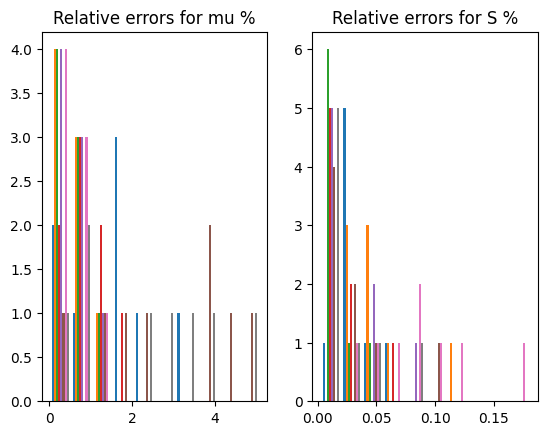

In [6]:
mu_true_torch = torch.from_numpy(mu) #Converts mean coefficients to torch. 
S_true_torch = torch.from_numpy(S) #Converts true covariance to torch. 

mu_est = Model_Implementation['mu_h'] #Obtains mean estimate. 
S_est = Model_Implementation['S_h'] #Obtains covariance estimate. 


fig,ax = plt.subplots(nrows = 1, ncols = 2)

ax[0].hist( (torch.abs(mu_est - mu_true_torch) /torch.abs(mu_true_torch) ).numpy() )
ax[0].set_title("Relative errors for mu %")

ax[1].hist( (torch.abs(S_est - S_true_torch) /torch.abs(S_true_torch) ).numpy()    )
ax[1].set_title( "Relative errors for S %")
plt.show()




# 4. Practical considerations. 


When using the code discussed, there are a couple of factors that must be considered: 

1. There is a balance between the quality of estimation, the number of observation points of the different galaxies, and the number of B-Splines and line profiles used. 
2. The magnitudes of the worked quantities may affect the iterative processes and the results. Recall that the largest number allowed by float64 arithmetic in torch is $1.7977 \times 10 ^{308}$ while the smallest is $2.2251 \times 10^{-308}$. If, for example, the entries of one of the $\textbf{m}_o$ has an order of magnitude of $1\times 10 ^{150}$, the iterative process will fail when taking the outer products $\textbf{m}_o \textbf{m}_o^T $. 
3. More parameters and galaxies can increase execution time significantly aswell as memory usage. Note that each iteration requieres the computation of $O+1$ inverse matrices- i.e. $\hat{\Sigma}^{-1}$ and the $(\hat{\Sigma}^{-1} + \textbf{X}_o^T \textbf{T}_o \textbf{X}_o)^{-1}$'s- each taking $\mathcal{O}(B_f^3)$ flops. In addition, as currently programmed, the **EM_alg** requieres the storage of two $O \times B_f \times B_f$ float64 tensors. 

# References:

1. https://github.com/sdss/dr19_tutorials/blob/main/BHM_classroom.ipynb
2. https://arxiv.org/abs/2310.19340